In [1]:
#The main Jupyter notebook for running our simulation. For now we can also use this notebook to test out code segments

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import CSJModel as csj

In [2]:
#Model Parameters
length_of_growing_season = 150
n_seasons_per_trial = 10
n_trials = 10000
n_plots = 4
plot_capacity = 1000
initial_soil_sat = 0.5
base_soil_sat_loss_rate = 0.05
biomass_water_demand_rate = 0.001
end_of_season_die_off = 0.9
temp = 20
rel_hum = .7

In [ ]:
trial_list = []
for trial in range(n_trials):
    trial_dict = {}

In [18]:
class Plant:
    
    def __init__(self, n, rate, k, alpha):
        self.name = str(n)
        self.base_growth_rate = rate
        self.ideal_soil_sat = k
        self.ideal_sat_alpha = alpha
    
    def growth_rate(self, soil_sat):
        return (-1 * self.ideal_sat_alpha * (soil_sat - self.ideal_soil_sat) ** 2 + 1) * self.base_growth_rate

test = Plant('my_plant', 0.01, 0.5, 10)

In [19]:
class Plot:
    
    def __init__(self, plant_list, cap, sat, h2o_base_rate, h2o_biomass_rate):
        self.species_list = plant_list
        self.capacity = cap
        self.soil_saturation = sat
        self.base_saturation_rate = h2o_base_rate
        self.biomass_h2o_demand = h2o_biomass_rate
    
    def dry(self):
        total_biomass = 0
        for plant_dict in self.species_list:
            total_biomass += plant_dict['biomass']
        self.soil_saturation = (1 - (self.base_saturation_rate + self.biomass_h2o_demand * total_biomass)) * self.soil_saturation
    
    def wet(self, sat):
        self.soil_saturation = sat



In [23]:
import random
test_plot = Plot([{'species':test, 'biomass':10}], plot_capacity, initial_soil_sat, base_soil_sat_loss_rate, biomass_water_demand_rate)

daily_list = []
for time in range(length_of_growing_season):
    for plant_dict in test_plot.species_list:
        plant_dict['biomass'] += plant_dict['species'].growth_rate(test_plot.soil_saturation) * plant_dict['biomass'] * (1 - (plant_dict['biomass']/test_plot.capacity))
        if random.randint(0, 100) > 94:
            test_plot.wet(0.8)
        else:
            test_plot.dry()
    daily_list.append({'time': time, 'biomass': test_plot.species_list[0]['biomass'], 'soil_sat': test_plot.soil_saturation})
df = pd.DataFrame.from_records(daily_list, index='time')
df
        

,biomass,soil_sat
time,,
0,10.099000,0.469950
1,10.198067,0.441660
2,10.295573,0.415030
3,10.390112,0.389967
4,10.480484,0.366381
...,...,...
145,19.432433,0.644882
146,19.582983,0.600009
147,19.755775,0.558155


In [25]:
df.describe()

,biomass,soil_sat
count,150.000000,150.000000
mean,14.796386,0.431194
std,2.865822,0.219110
min,10.099000,0.061393
25%,12.219865,0.240053
50%,14.969650,0.416034
75%,17.348418,0.612023
max,20.137618,0.800000


<Axes: xlabel='time'>

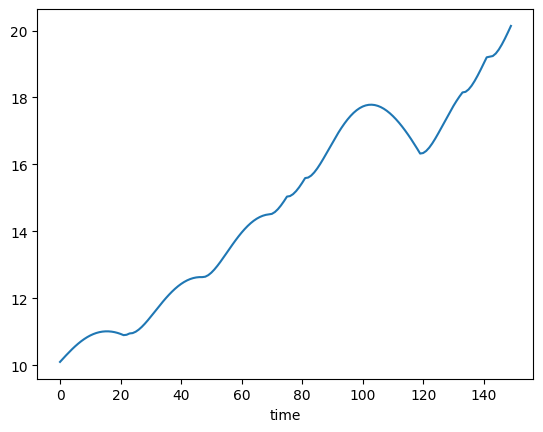

In [26]:
df['biomass'].plot()

<Axes: xlabel='time'>

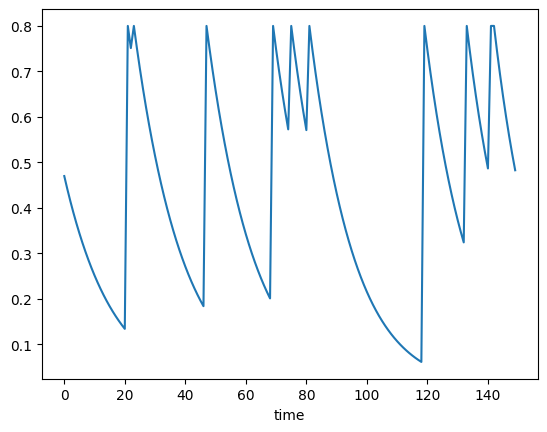

In [27]:
df['soil_sat'].plot()